All the imports

In [1]:
import pandas as pd
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
from src.utils.analysis_tools import *


In [2]:
path = "./data/"
filtered_meta = pd.read_csv(path+"final_yt_metadata.csv")

C:\Users\leoga\AppData\Local\Temp\ipykernel_19564\803352734.py:2: DtypeWarning: Columns (4,6,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_meta = pd.read_csv(path+"final_yt_metadata.csv")


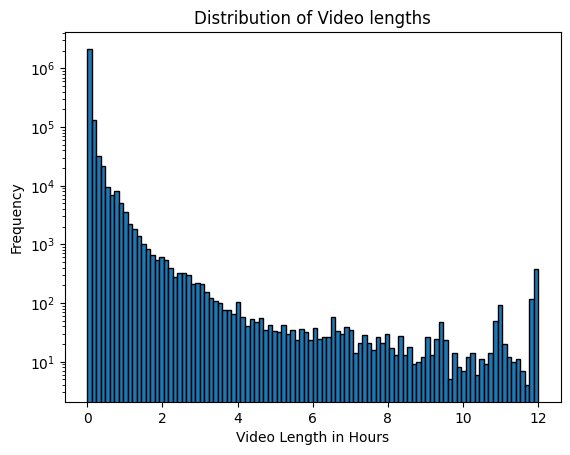

12 hours is the limit for livestream uploads


In [3]:
plot_video_stat(filtered_meta, 'duration')

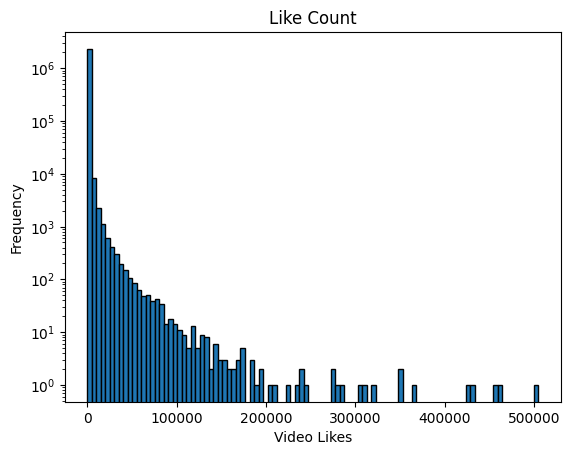

In [4]:
plot_video_stat(filtered_meta, 'like_count')

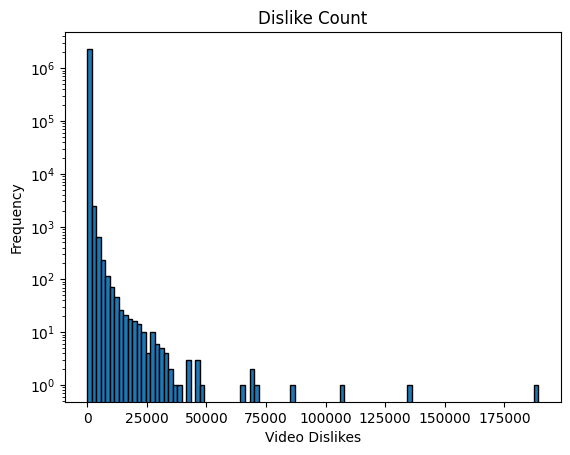

In [5]:
plot_video_stat(filtered_meta, 'dislike_count')

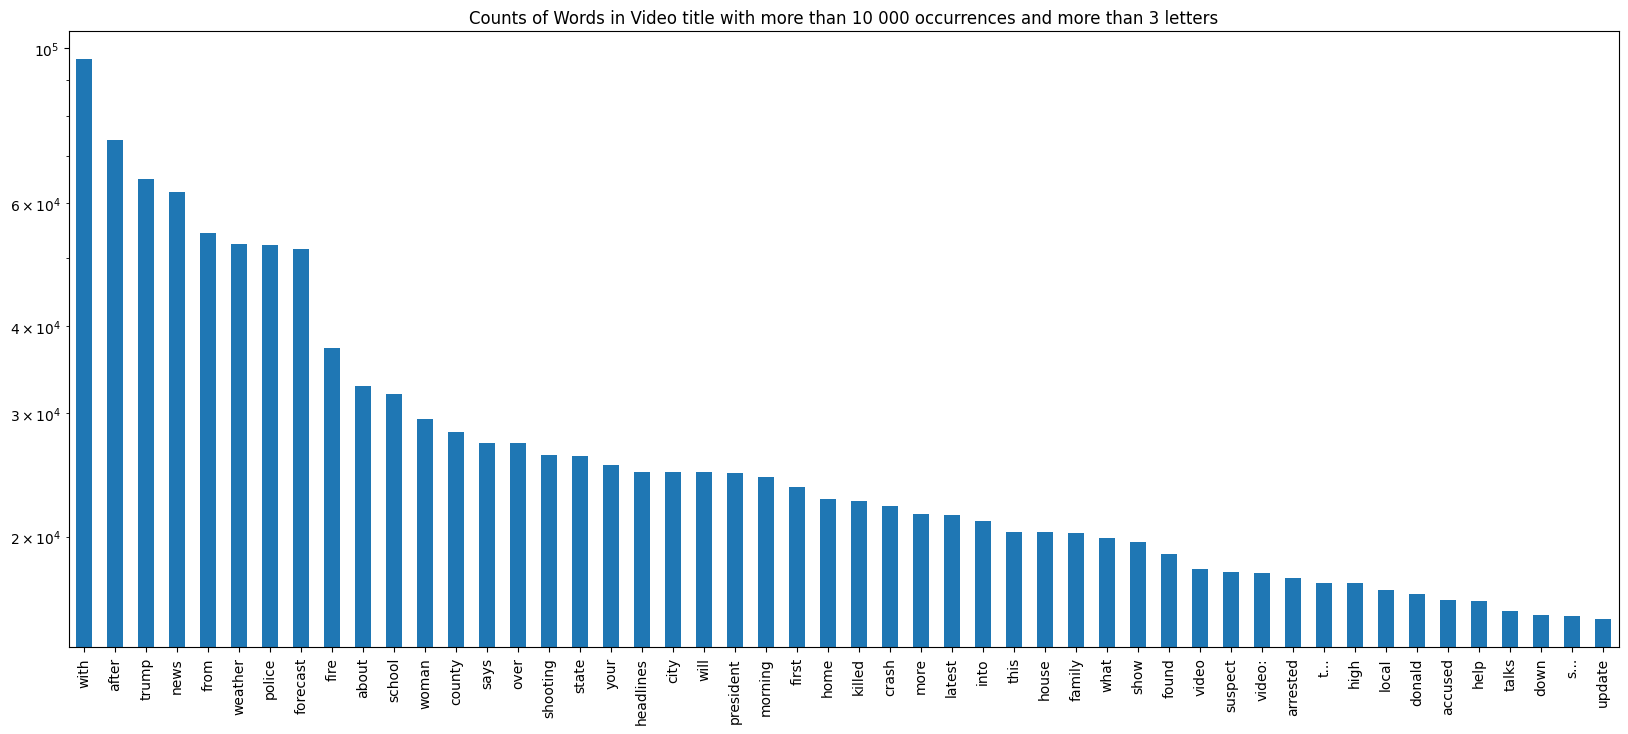

In [11]:
plot_most_common_words(filtered_meta, 'title', 50)
plot_most_common_words(filtered_meta, 'description', 50)

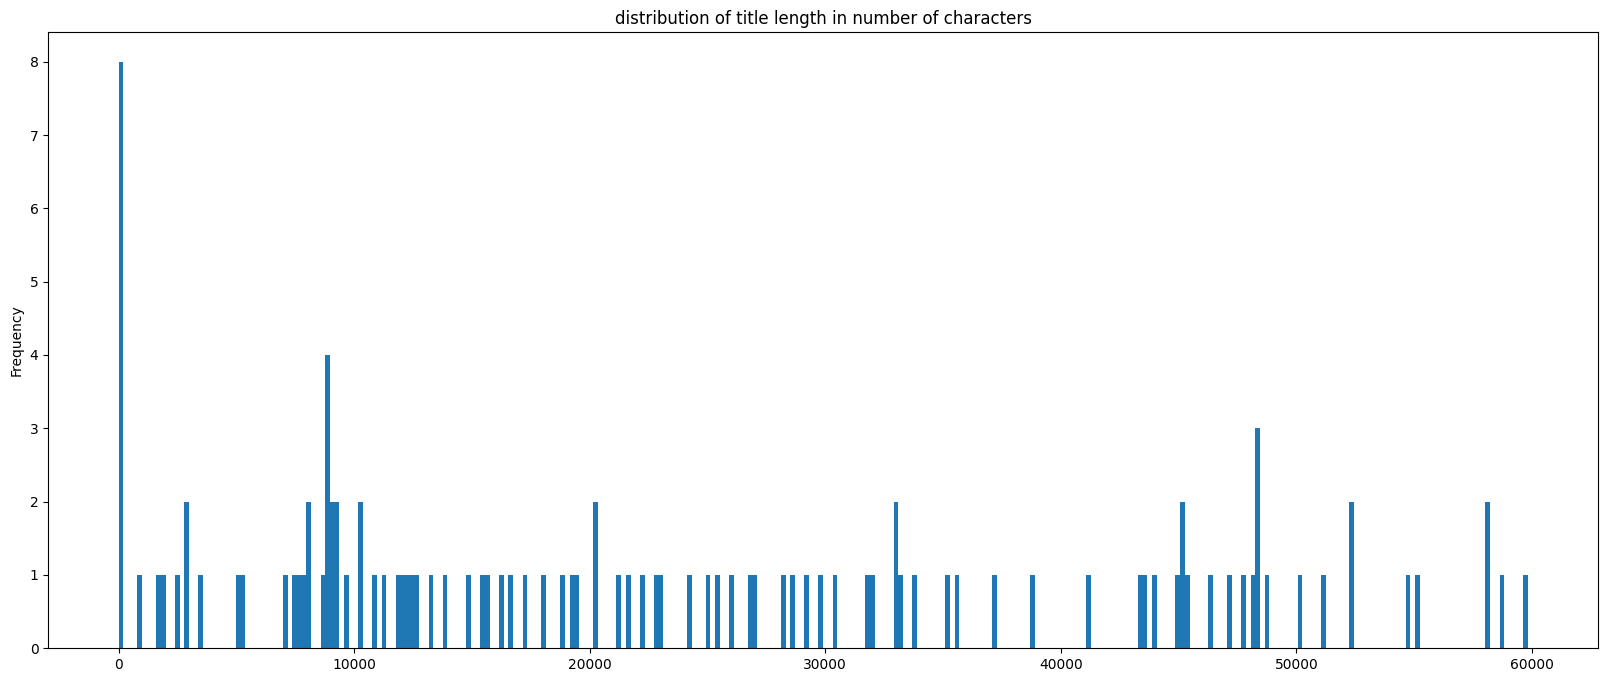

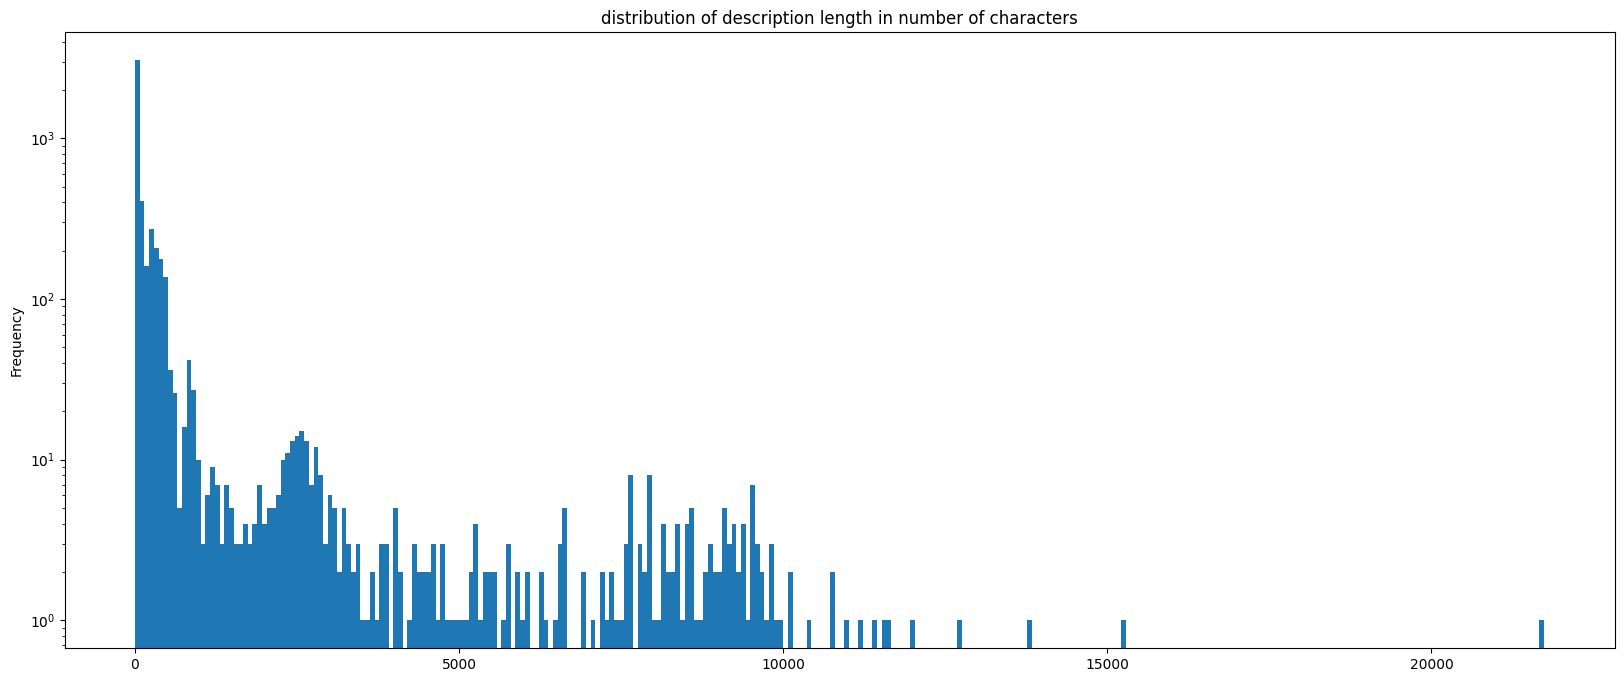

In [22]:
plot_text_len_char(filtered_meta, 'title')
plot_text_len_char(filtered_meta, 'description')

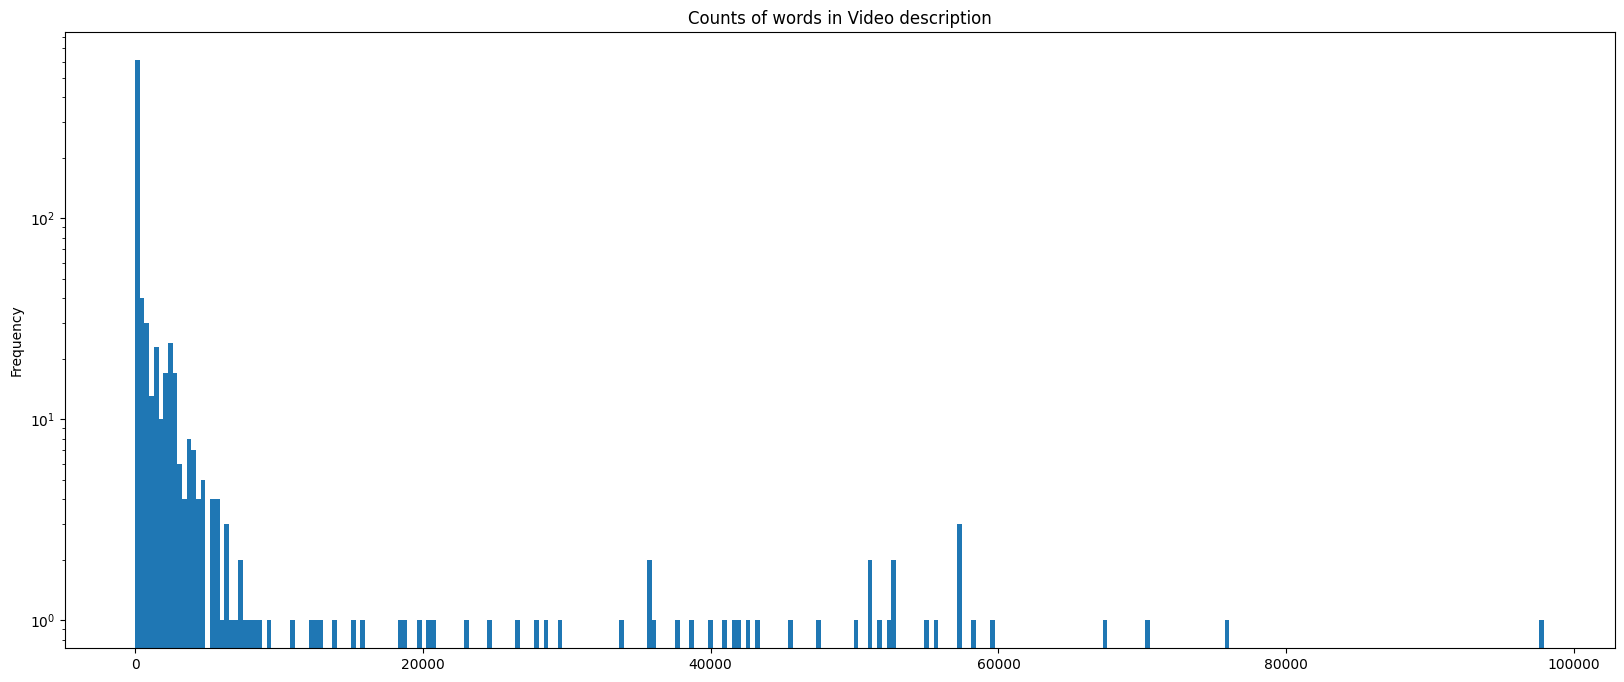

In [34]:

plot_text_len_words(filtered_meta, 'description')
